## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [14]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape) # 輸入層

    for i, n_units in enumerate(num_neurons): # 隱藏層
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                               activation="relu", 
                               name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                               activation="relu", 
                               name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)

    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x) # 輸出層

    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [9]:
?keras.callbacks.ReduceLROnPlateau

In [10]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.1, 0.25, 0.5]
redice_lr_patient = [5, 10]

In [16]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor= reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience= reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.10, reduce_patient: 5
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
______________________________________________________________

49/49 [==============================] - 1s 29ms/step - loss: 1.2656 - accuracy: 0.5595 - val_loss: 1.4854 - val_accuracy: 0.4747
Epoch 14/25
49/49 [==============================] - 1s 29ms/step - loss: 1.2441 - accuracy: 0.5663 - val_loss: 1.4745 - val_accuracy: 0.4826
Epoch 15/25
49/49 [==============================] - 2s 32ms/step - loss: 1.2243 - accuracy: 0.5753 - val_loss: 1.4651 - val_accuracy: 0.4860
Epoch 16/25
49/49 [==============================] - 1s 28ms/step - loss: 1.2020 - accuracy: 0.5851 - val_loss: 1.4644 - val_accuracy: 0.4840
Epoch 17/25
49/49 [==============================] - 1s 29ms/step - loss: 1.1827 - accuracy: 0.5902 - val_loss: 1.4679 - val_accuracy: 0.4834
Epoch 18/25
49/49 [==============================] - 1s 29ms/step - loss: 1.1627 - accuracy: 0.5978 - val_loss: 1.4639 - val_accuracy: 0.4895
Epoch 19/25
49/49 [==============================] - 1s 27ms/step - loss: 1.1444 - accuracy: 0.6042 - val_loss: 1.4493 - val_accuracy: 0.4915
Epoch 20/25
49/49 

Epoch 1/25
49/49 [==============================] - 1s 27ms/step - loss: 2.2011 - accuracy: 0.2774 - val_loss: 2.1663 - val_accuracy: 0.1655
Epoch 2/25
49/49 [==============================] - 1s 24ms/step - loss: 1.7557 - accuracy: 0.3892 - val_loss: 2.0024 - val_accuracy: 0.2809
Epoch 3/25
49/49 [==============================] - 1s 24ms/step - loss: 1.6321 - accuracy: 0.4302 - val_loss: 1.8414 - val_accuracy: 0.3656
Epoch 4/25
49/49 [==============================] - 1s 25ms/step - loss: 1.5594 - accuracy: 0.4530 - val_loss: 1.7228 - val_accuracy: 0.4076
Epoch 5/25
49/49 [==============================] - 1s 24ms/step - loss: 1.5052 - accuracy: 0.4733 - val_loss: 1.6367 - val_accuracy: 0.4338
Epoch 6/25
49/49 [==============================] - 1s 24ms/step - loss: 1.4624 - accuracy: 0.4888 - val_loss: 1.5794 - val_accuracy: 0.4434
Epoch 7/25
49/49 [==============================] - 1s 24ms/step - loss: 1.4237 - accuracy: 0.5041 - val_loss: 1.5442 - val_accuracy: 0.4593
Epoch 8/25
49

49/49 [==============================] - 1s 24ms/step - loss: 1.0826 - accuracy: 0.6282 - val_loss: 1.4521 - val_accuracy: 0.4901
Epoch 24/25
49/49 [==============================] - 1s 24ms/step - loss: 1.0647 - accuracy: 0.6366 - val_loss: 1.4473 - val_accuracy: 0.4943
Epoch 25/25
49/49 [==============================] - 1s 24ms/step - loss: 1.0497 - accuracy: 0.6410 - val_loss: 1.4469 - val_accuracy: 0.4957
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 10
Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_18 (Batc (None, 256)               1024      
__________________________________________

49/49 [==============================] - 1s 24ms/step - loss: 0.9562 - accuracy: 0.6640 - val_loss: 1.9071 - val_accuracy: 0.3618
Epoch 11/25
49/49 [==============================] - 1s 24ms/step - loss: 0.9173 - accuracy: 0.6793 - val_loss: 1.7351 - val_accuracy: 0.4329
Epoch 12/25
49/49 [==============================] - 1s 24ms/step - loss: 0.8721 - accuracy: 0.6972 - val_loss: 1.6581 - val_accuracy: 0.4489
Epoch 13/25
49/49 [==============================] - ETA: 0s - loss: 0.8253 - accuracy: 0.7133
Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
49/49 [==============================] - 1s 24ms/step - loss: 0.8253 - accuracy: 0.7133 - val_loss: 1.7503 - val_accuracy: 0.4366
Epoch 14/25
49/49 [==============================] - 1s 24ms/step - loss: 0.6952 - accuracy: 0.7709 - val_loss: 1.3729 - val_accuracy: 0.5346
Epoch 15/25
49/49 [==============================] - 1s 25ms/step - loss: 0.6401 - accuracy: 0.7957 - val_loss: 1.3704 - val_accuracy: 0.5

_________________________________________________________________
Epoch 1/25
49/49 [==============================] - 2s 31ms/step - loss: 2.2565 - accuracy: 0.2528 - val_loss: 2.1534 - val_accuracy: 0.2337
Epoch 2/25
49/49 [==============================] - 1s 26ms/step - loss: 1.8712 - accuracy: 0.3550 - val_loss: 2.0286 - val_accuracy: 0.3113
Epoch 3/25
49/49 [==============================] - 1s 26ms/step - loss: 1.7681 - accuracy: 0.3873 - val_loss: 1.9091 - val_accuracy: 0.3419
Epoch 4/25
49/49 [==============================] - 1s 27ms/step - loss: 1.7074 - accuracy: 0.4069 - val_loss: 1.8173 - val_accuracy: 0.3641
Epoch 5/25
49/49 [==============================] - 1s 27ms/step - loss: 1.6626 - accuracy: 0.4206 - val_loss: 1.7508 - val_accuracy: 0.3862
Epoch 6/25
49/49 [==============================] - 1s 27ms/step - loss: 1.6284 - accuracy: 0.4316 - val_loss: 1.7003 - val_accuracy: 0.4040
Epoch 7/25
49/49 [==============================] - 1s 27ms/step - loss: 1.6001 - accura

Epoch 23/25
49/49 [==============================] - 1s 25ms/step - loss: 1.3683 - accuracy: 0.5252 - val_loss: 1.5530 - val_accuracy: 0.4583
Epoch 24/25
49/49 [==============================] - 1s 25ms/step - loss: 1.3601 - accuracy: 0.5275 - val_loss: 1.5477 - val_accuracy: 0.4615
Epoch 25/25
49/49 [==============================] - 1s 24ms/step - loss: 1.3526 - accuracy: 0.5294 - val_loss: 1.5462 - val_accuracy: 0.4591
Numbers of exp: 10, reduce_factor: 0.50, reduce_patient: 5
Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_33 (Batc (None, 256)               1024      
______________________________

Epoch 10/25
49/49 [==============================] - 1s 28ms/step - loss: 1.5137 - accuracy: 0.4725 - val_loss: 1.6140 - val_accuracy: 0.4323
Epoch 11/25
49/49 [==============================] - 1s 27ms/step - loss: 1.4970 - accuracy: 0.4772 - val_loss: 1.6043 - val_accuracy: 0.4395
Epoch 12/25
49/49 [==============================] - 1s 25ms/step - loss: 1.4804 - accuracy: 0.4833 - val_loss: 1.5974 - val_accuracy: 0.4412
Epoch 13/25
49/49 [==============================] - 1s 26ms/step - loss: 1.4667 - accuracy: 0.4890 - val_loss: 1.5927 - val_accuracy: 0.4442
Epoch 14/25
49/49 [==============================] - 1s 26ms/step - loss: 1.4533 - accuracy: 0.4925 - val_loss: 1.5904 - val_accuracy: 0.4453
Epoch 15/25
49/49 [==============================] - 1s 28ms/step - loss: 1.4404 - accuracy: 0.4979 - val_loss: 1.5825 - val_accuracy: 0.4464
Epoch 16/25
49/49 [==============================] - 1s 28ms/step - loss: 1.4289 - accuracy: 0.5022 - val_loss: 1.5800 - val_accuracy: 0.4510
Epoch 

Epoch 1/25
49/49 [==============================] - 2s 33ms/step - loss: 2.6193 - accuracy: 0.1655 - val_loss: 2.2448 - val_accuracy: 0.1519
Epoch 2/25
49/49 [==============================] - 1s 28ms/step - loss: 2.2627 - accuracy: 0.2447 - val_loss: 2.1657 - val_accuracy: 0.1979
Epoch 3/25
49/49 [==============================] - 1s 28ms/step - loss: 2.1013 - accuracy: 0.2868 - val_loss: 2.0784 - val_accuracy: 0.2387
Epoch 4/25
49/49 [==============================] - 1s 28ms/step - loss: 2.0002 - accuracy: 0.3125 - val_loss: 1.9929 - val_accuracy: 0.2815
Epoch 5/25
49/49 [==============================] - 1s 28ms/step - loss: 1.9279 - accuracy: 0.3341 - val_loss: 1.9218 - val_accuracy: 0.3087
Epoch 6/25
49/49 [==============================] - 1s 28ms/step - loss: 1.8741 - accuracy: 0.3506 - val_loss: 1.8684 - val_accuracy: 0.3329
Epoch 7/25
49/49 [==============================] - 1s 28ms/step - loss: 1.8296 - accuracy: 0.3642 - val_loss: 1.8363 - val_accuracy: 0.3488
Epoch 8/25
49

49/49 [==============================] - 1s 27ms/step - loss: 1.5041 - accuracy: 0.4756 - val_loss: 1.6399 - val_accuracy: 0.4362
Epoch 24/25
49/49 [==============================] - 1s 27ms/step - loss: 1.4922 - accuracy: 0.4815 - val_loss: 1.6357 - val_accuracy: 0.4329
Epoch 25/25
49/49 [==============================] - 1s 27ms/step - loss: 1.4822 - accuracy: 0.4840 - val_loss: 1.6305 - val_accuracy: 0.4381
Numbers of exp: 15, reduce_factor: 0.25, reduce_patient: 10
Model: "functional_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_48 (Batc (None, 256)               1024      
_________________________________________

49/49 [==============================] - 1s 28ms/step - loss: 1.7369 - accuracy: 0.3982 - val_loss: 1.7869 - val_accuracy: 0.3806
Epoch 11/25
49/49 [==============================] - 1s 28ms/step - loss: 1.7108 - accuracy: 0.4053 - val_loss: 1.7716 - val_accuracy: 0.3858
Epoch 12/25
49/49 [==============================] - 1s 27ms/step - loss: 1.6869 - accuracy: 0.4143 - val_loss: 1.7564 - val_accuracy: 0.3937
Epoch 13/25
49/49 [==============================] - 1s 27ms/step - loss: 1.6661 - accuracy: 0.4215 - val_loss: 1.7438 - val_accuracy: 0.3965
Epoch 14/25
49/49 [==============================] - 1s 27ms/step - loss: 1.6469 - accuracy: 0.4263 - val_loss: 1.7326 - val_accuracy: 0.3998
Epoch 15/25
49/49 [==============================] - 1s 27ms/step - loss: 1.6286 - accuracy: 0.4331 - val_loss: 1.7209 - val_accuracy: 0.4054
Epoch 16/25
49/49 [==============================] - 1s 27ms/step - loss: 1.6117 - accuracy: 0.4380 - val_loss: 1.7184 - val_accuracy: 0.4066
Epoch 17/25
49/49 

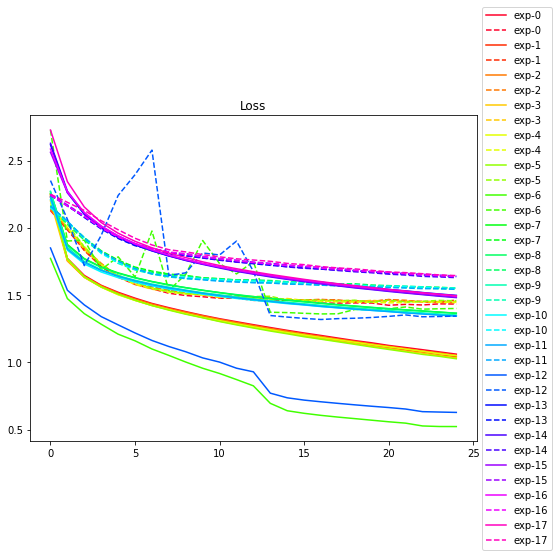

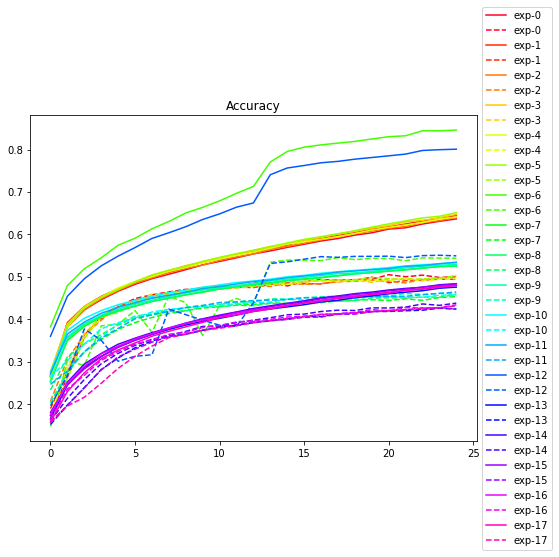

In [17]:
# 視覺化
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow') # 顏色
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()